In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount("/content/drive/")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


In [ ]:
#Using fast ai

In [ ]:
import torchvision
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio

In [ ]:
# tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
#                       max_warp=0.,
#                       xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
#                                  symmetric_warp(magnitude=(-0.2, 0.2))])

tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05)

data = ImageDataBunch.from_folder('/content/drive/MyDrive/','cars_trainn0','cars_validd',
                                  ds_tfms=tfms
                                  ,size=224,bs=64).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


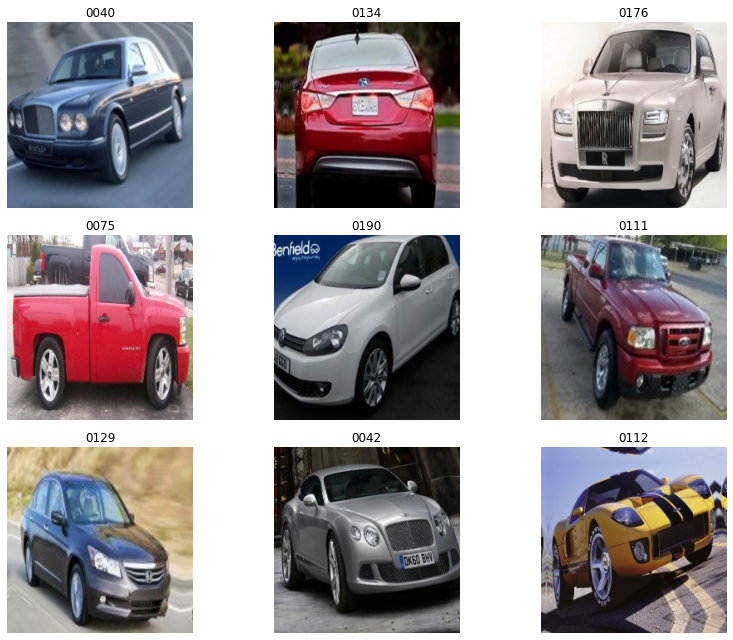

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

In [ ]:
# class names and number of classes
# print(data.classes)
len(data.classes),data.c

(196, 196)

In [ ]:
!pip install pretrainedmodels
import pretrainedmodels

     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=cec6451e28023c876e8e6fdcb947f8bfba4a369507a69a15953feb2bd7fdad3f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [ ]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [ ]:
def resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [ ]:
learn = cnn_learner(data, resnext50_32x4d, pretrained=True, cut=-2,
                    split_on=lambda m: (m[0][3], m[1]), 
                    metrics=[accuracy])
learn.loss_fn = FocalLoss()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [ ]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 5.75E-03


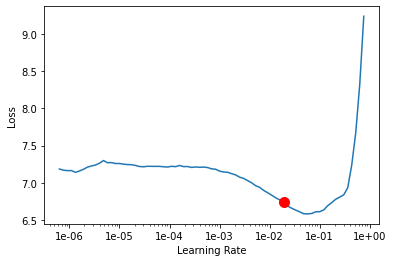

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(32, max_lr=slice(2e-2), wd=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,5.165489,3.571305,0.219153,1:07:25
1,3.445503,2.734011,0.339472,1:11:26
2,2.648682,2.439049,0.409454,1:23:45
3,2.379896,2.394681,0.415592,1:27:18
4,2.326023,2.136092,0.468999,1:23:44
5,2.092603,1.982723,0.525476,1:14:48
6,1.746888,1.699615,0.570289,1:12:02
7,1.528410,1.694464,0.578883,1:14:21


In [ ]:
from fastai.vision import *
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(40,40), dpi=60)

In [ ]:
# learn.export()
learn.save('/content/drive/MyDrive/models/rnext50')

In [ ]:
import pickle
file = open("rnet.pkl", "wb") # opening a new file in write mode
pickle.dump(learn '/content/drive/MyDrive/rnext50.pkl') # dumping created model into a pickle file

In [ ]:
from flask import Flask

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    json_ = request.json
    query_df = pd.DataFrame(json_)
    query = pd.get_dummies(query_df)
    
    classifier = joblib.load('abc.pkl')
    prediction = classifier.predict(query)
    return jsonify({'prediction': list(prediction)})


if __name__ == '__main__':
    app.run(port=8081)
    app.close()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8081/ (Press CTRL+C to quit)
